Predicting LV power using LSTM and with a sample frequency of 20 mins and  two time  steps.  

https://www.kaggle.com/berkerisen/wind-turbine-scada-dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
from sklearn.metrics import mean_squared_error , r2_score

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [5]:
train.head()

,Date,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904
1,2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113
2,2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789
3,2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087
4,2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286


In [6]:
test.head()

,Date,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°)
0,2018-12-26 00:00:00,394.483887,11.23912,3350.492384,25.707260
1,2018-12-26 00:10:00,369.472809,11.01617,3278.121125,25.653749
2,2018-12-26 00:20:00,342.465393,10.68914,3151.278731,26.026560
3,2018-12-26 00:30:00,379.872101,10.95354,3255.790569,25.367300
4,2018-12-26 00:40:00,346.712891,10.38256,3007.924280,24.966379


In [7]:
train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])

In [8]:
cols = train.columns.tolist()

In [9]:
train.set_index(['Date'] , inplace = True)
test.set_index(['Date'] , inplace = True)

Text(0.5, 1.0, 'train data -LV ActivePower (kW)')

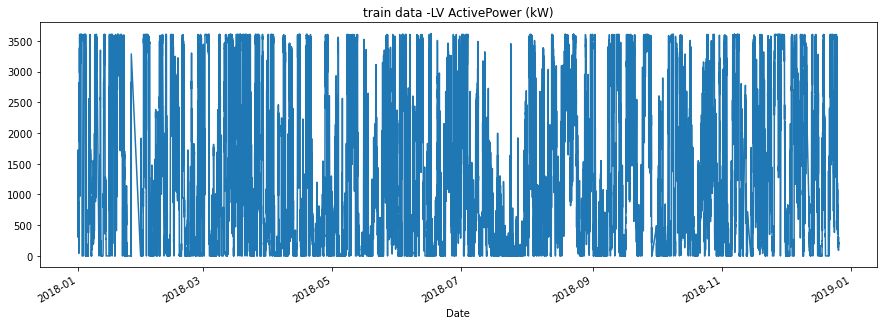

In [10]:
## plot wind power
plt.figure(figsize = (15,5))
train[cols[1]].plot()
plt.title('train data -' + cols[1])


Text(0.5, 1.0, 'test data - LV ActivePower (kW)')

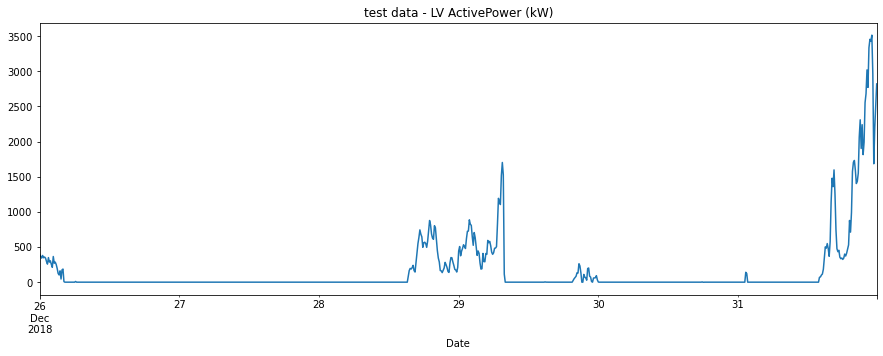

In [11]:
## plot test data 
plt.figure(figsize = (15,5))
test[cols[1]].plot()
plt.title('test data - ' +  cols[1])

In [12]:
## Shift the values by 1 and 2 to create features 
train[cols[1] + '+1'] = train[cols[1]].shift(-1)
train[cols[1] + '+2'] = train[cols[1]].shift(-2)


In [13]:
train.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),LV ActivePower (kW)+1,LV ActivePower (kW)+2
Date,,,,,,
2018-01-01 00:00:00,380.047791,5.311336,416.328908,259.994904,453.769196,306.376587
2018-01-01 00:10:00,453.769196,5.672167,519.917511,268.641113,306.376587,419.645905
2018-01-01 00:20:00,306.376587,5.216037,390.900016,272.564789,419.645905,380.650696
2018-01-01 00:30:00,419.645905,5.659674,516.127569,271.258087,380.650696,402.391998
2018-01-01 00:40:00,380.650696,5.577941,491.702972,265.674286,402.391998,447.605713


In [14]:
train.isnull().sum()

LV ActivePower (kW)              0
Wind Speed (m/s)                 0
Theoretical_Power_Curve (KWh)    0
Wind Direction (°)               0
LV ActivePower (kW)+1            1
LV ActivePower (kW)+2            2
dtype: int64

In [15]:
train.tail()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),LV ActivePower (kW)+1,LV ActivePower (kW)+2
Date,,,,,,
2018-12-25 23:10:00,215.484207,9.242176,2301.134108,30.515120,190.253998,261.101013
2018-12-25 23:20:00,190.253998,8.737427,1976.292032,26.657761,261.101013,212.121506
2018-12-25 23:30:00,261.101013,9.707693,2596.541416,25.608040,212.121506,296.951111
2018-12-25 23:40:00,212.121506,9.075032,2192.469413,26.380341,296.951111,NaN
2018-12-25 23:50:00,296.951111,10.106640,2856.644995,25.966070,NaN,NaN


In [16]:
train.dropna(inplace = True )

In [17]:
## shift the values by 1 and 2 to create featues.
test[cols[1] + '+1'] = test[cols[1]].shift(-1)
test[cols[1] + '+2'] = test[cols[1]].shift(-2)

In [18]:
test.head()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),LV ActivePower (kW)+1,LV ActivePower (kW)+2
Date,,,,,,
2018-12-26 00:00:00,394.483887,11.23912,3350.492384,25.707260,369.472809,342.465393
2018-12-26 00:10:00,369.472809,11.01617,3278.121125,25.653749,342.465393,379.872101
2018-12-26 00:20:00,342.465393,10.68914,3151.278731,26.026560,379.872101,346.712891
2018-12-26 00:30:00,379.872101,10.95354,3255.790569,25.367300,346.712891,358.168488
2018-12-26 00:40:00,346.712891,10.38256,3007.924280,24.966379,358.168488,342.632294


In [19]:
test.tail()

,LV ActivePower (kW),Wind Speed (m/s),Theoretical_Power_Curve (KWh),Wind Direction (°),LV ActivePower (kW)+1,LV ActivePower (kW)+2
Date,,,,,,
2018-12-31 23:10:00,2963.980957,11.404030,3397.190793,80.502724,1684.353027,2201.106934
2018-12-31 23:20:00,1684.353027,7.332648,1173.055771,84.062599,2201.106934,2515.694092
2018-12-31 23:30:00,2201.106934,8.435358,1788.284755,84.742500,2515.694092,2820.466064
2018-12-31 23:40:00,2515.694092,9.421366,2418.382503,84.297913,2820.466064,NaN
2018-12-31 23:50:00,2820.466064,9.979332,2779.184096,82.274620,NaN,NaN


In [20]:
test.dropna(inplace = True)

In [21]:
## resample the records so that for frequency of 20 mins , values are averaged. 
train_rs = train.resample('20min')[[cols[1], cols[1]+'+1', cols[1]+'+2']].mean()
test_rs = test.resample('20min')[[cols[1],cols[1]+'+1',cols[1]+'+2']].mean()

In [22]:
train_rs.isnull().sum()

LV ActivePower (kW)      995
LV ActivePower (kW)+1    995
LV ActivePower (kW)+2    995
dtype: int64

In [23]:
train_rs.dropna(inplace = True)

In [24]:
test_rs.isnull().sum()

LV ActivePower (kW)      0
LV ActivePower (kW)+1    0
LV ActivePower (kW)+2    0
dtype: int64

In [25]:
## set the features 
trainX = train_rs[[cols[1], cols[1]+'+1']].values
testX = test_rs[[cols[1], cols[1]+'+1']].values

In [26]:
## set the response/predictor variable.
trainY = train_rs[cols[1]+'+2'].values
#
testY = test_rs[cols[1]+'+2'].values

In [27]:
trainX.shape , trainY.shape , testX.shape , testY.shape

((24852, 2), (24852,), (431, 2), (431,))

In [28]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (len(trainX), 2, 1))
testX = np.reshape(testX, (len(testX), 2, 1))


In [29]:
# create and fit the LSTM network
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(4, input_shape=(2, 1)))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=50, batch_size=1, verbose=2)

Epoch 1/50
24852/24852 - 28s - loss: 3375925.5000
Epoch 2/50
24852/24852 - 27s - loss: 3203490.2500
Epoch 3/50
24852/24852 - 38s - loss: 3040698.7500
Epoch 4/50
24852/24852 - 40s - loss: 2885755.0000
Epoch 5/50
24852/24852 - 37s - loss: 2739015.0000
Epoch 6/50
24852/24852 - 36s - loss: 2599389.2500
Epoch 7/50
24852/24852 - 41s - loss: 2466986.0000
Epoch 8/50
24852/24852 - 34s - loss: 2340832.5000
Epoch 9/50
24852/24852 - 37s - loss: 2221069.7500
Epoch 10/50
24852/24852 - 32s - loss: 2103499.5000
Epoch 11/50
24852/24852 - 36s - loss: 1969567.8750
Epoch 12/50
24852/24852 - 35s - loss: 1843411.0000
Epoch 13/50
24852/24852 - 39s - loss: 1736704.8750
Epoch 14/50
24852/24852 - 37s - loss: 1631855.0000
Epoch 15/50
24852/24852 - 49s - loss: 1560087.1250
Epoch 16/50
24852/24852 - 40s - loss: 1465826.3750
Epoch 17/50
24852/24852 - 36s - loss: 1331817.5000
Epoch 18/50
24852/24852 - 39s - loss: 1235891.2500
Epoch 19/50
24852/24852 - 41s - loss: 1334757.2500
Epoch 20/50
24852/24852 - 35s - loss: 11

In [30]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [31]:
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))
print("R2 score :{}".format(r2_score(testY, testPredict)))

Train Score: 782.12 RMSE
Test Score: 167.32 RMSE
R2 score :0.8648843569220841


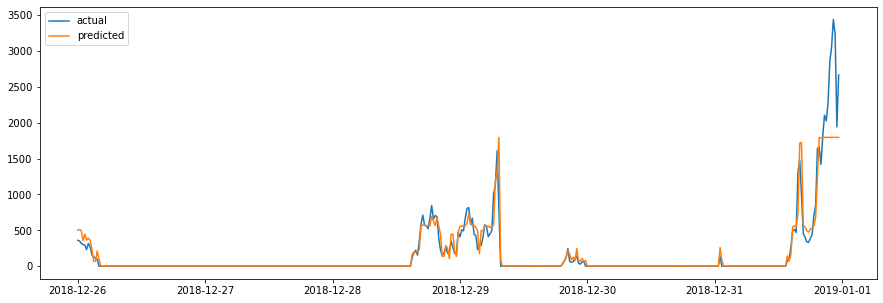

In [32]:
plt.figure(figsize = (15,5))
## create a df with the required test set dates as index 
result_df = test_rs[cols[1] + '+2'].reset_index()
result_df['predicted'] = testPredict
result_df.set_index(['Date'], inplace = True)
plt.plot(result_df[cols[1]+ '+2'] , label = 'actual')
plt.plot(result_df['predicted'] , label = 'predicted')
plt.legend()

By resampling to 20mins , and have two time steps , the test data RMSE has improved.  